In [47]:
#Libraries
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score
from uns_package.PCA import PCA # Personal Package
from sklearn.preprocessing import MinMaxScaler

## 11. Use your unsupervised Python package as a basis to build an HTTP server that receives a record as input and returns the class of the image. Suggestions: MNIST digit classifier, Iris classifier…

To solve this point i´m goint to use PCA from my personal library, with the resultant data a knn model is going to be trained a serialized to contruct the HTTP server
- Dataset: Iris

Loading Data

In [48]:
# Checking data type and non-null values
iris_data = pd.read_csv("Iris.csv",index_col='Id')
iris_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


In [49]:
# Checking dispertion values
iris_data.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [50]:
# Sampling the data
iris_data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


Label encoding since the algorithms we are going to use do not take non numerical or boolean data as inputs

In [51]:
iris_data.Species.replace({'Iris-setosa':0,'Iris-versicolor':1, 'Iris-virginica':2},inplace=True)

In [52]:
iris_data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,0
2,4.9,3.0,1.4,0.2,0
3,4.7,3.2,1.3,0.2,0
4,4.6,3.1,1.5,0.2,0
5,5.0,3.6,1.4,0.2,0


Checking the balance of the target data

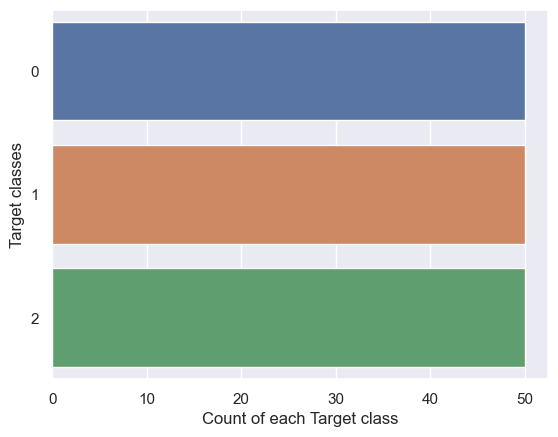

In [53]:
sns.countplot(y=iris_data.Species ,data=iris_data)
plt.xlabel("Count of each Target class")
plt.ylabel("Target classes")
plt.show()

Checking the distributon between features

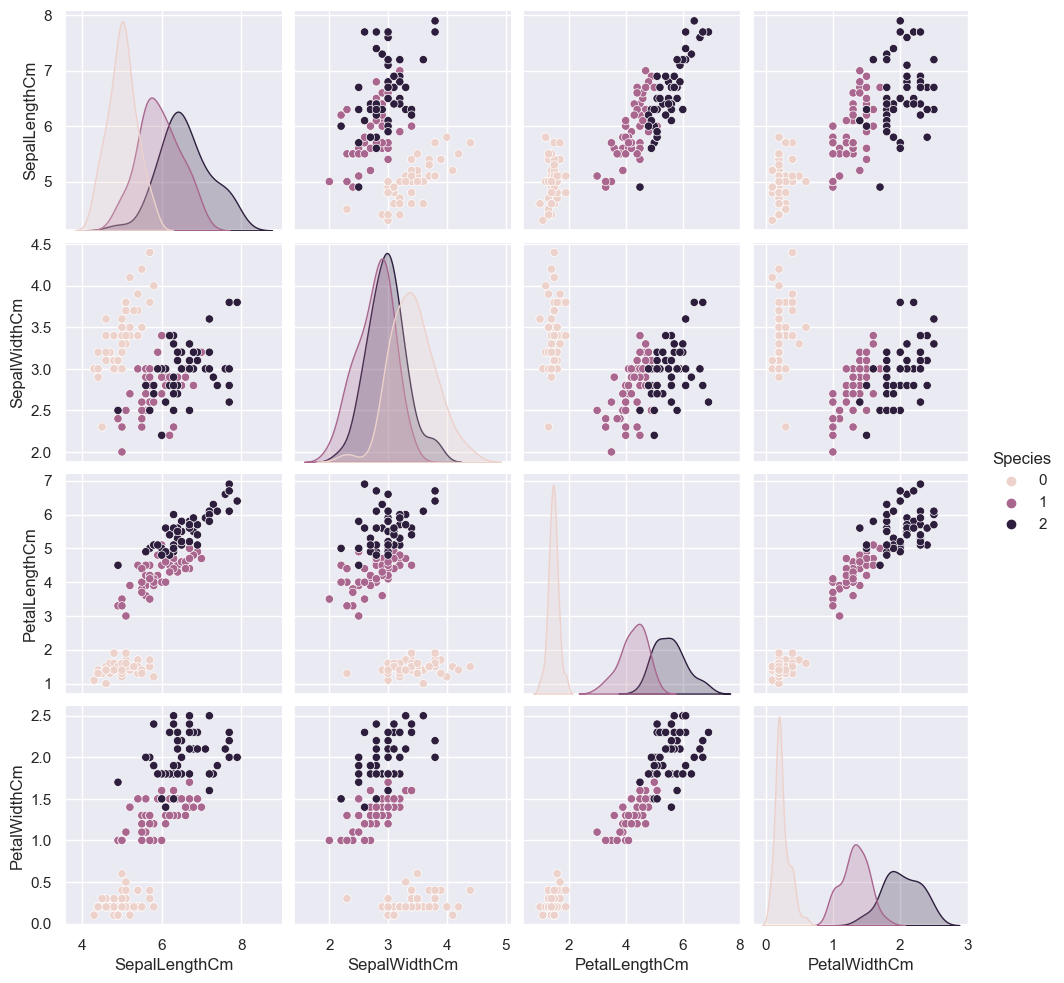

In [54]:
p=sns.pairplot(iris_data, hue = 'Species')

Calculating correlation

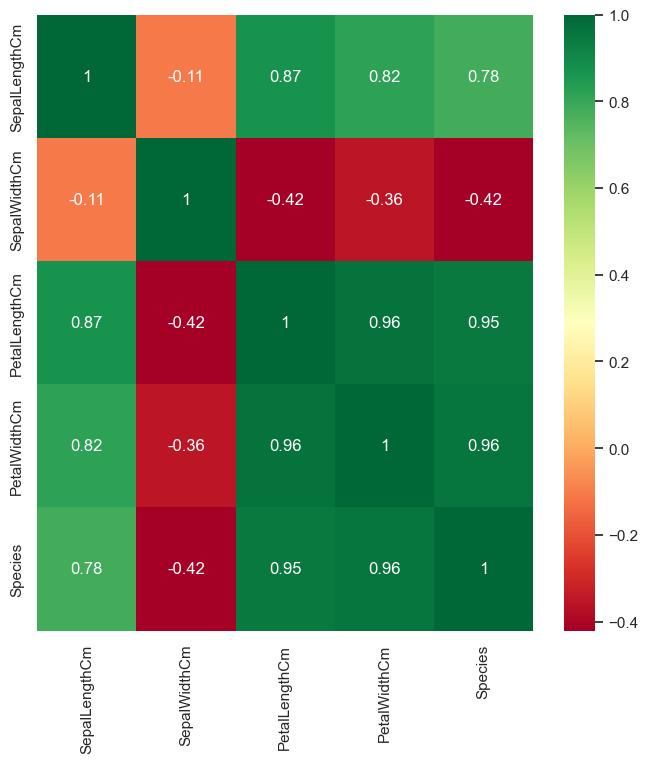

In [55]:
plt.figure(figsize=(8,8))
p=sns.heatmap(iris_data.corr(), annot=True,cmap='RdYlGn') 

Separating the data between predictor variables X and target data Y

In [56]:
X = iris_data.drop(['Species'],axis=1)
Y = iris_data.Species

Applying PCA from my personal library

In [57]:
# standardizing variables
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
X_norm = pd.DataFrame(X_norm, columns=X.columns)
X_norm.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,0.428704,0.439167,0.467571,0.457778
std,0.230018,0.180664,0.299054,0.317984
min,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.333333,0.101695,0.083333
50%,0.416667,0.416667,0.567797,0.500000
75%,0.583333,0.541667,0.694915,0.708333
max,1.000000,1.000000,1.000000,1.000000


In [58]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)
nombres = ["Comp_1", "Comp_2"]
X_pca = pd.DataFrame(X_pca.values, columns = nombres)
X_pca.head()

,Comp_1,Comp_2
0,-0.630361,-0.111556
1,-0.623546,0.100313
2,-0.669793,0.047220
3,-0.654633,0.098791
4,-0.648263,-0.137558


Plotting the first two components we can see good separation and compactation

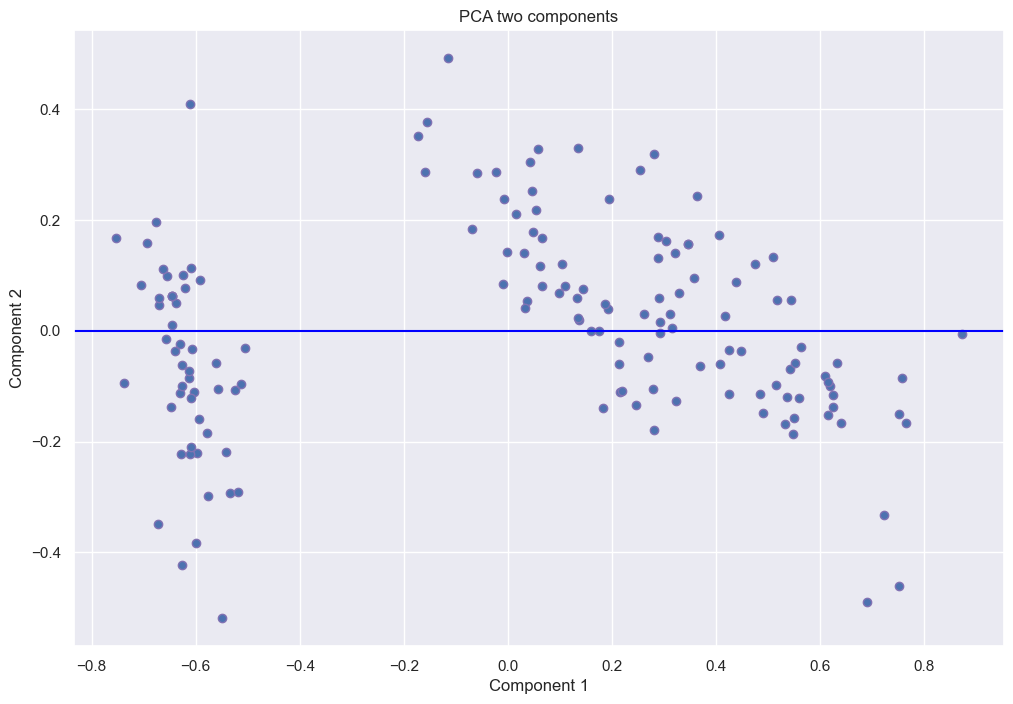

In [59]:
fig = plt.figure(figsize=(12,8)) 
plt.scatter(X_pca.values[:,0], X_pca.values[:,1], edgecolors="m")
plt.axhline(0, color="blue")
plt.title('PCA two components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

With 3 components we get 95% of explained variance

In [60]:
explained_variance=pca.explained_variance
sum(explained_variance[:2])

0.9587437487644832

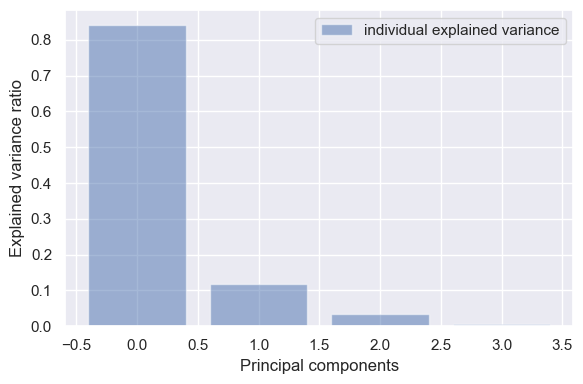

In [61]:
plt.figure(figsize=(6, 4))
plt.bar(range(4), explained_variance, alpha=0.5, align='center',
        label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

Training the model KNN

In [62]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, Y, test_size = 0.3, random_state=20, stratify=Y)

In [63]:
knn_pca = KNeighborsClassifier(5)
knn_pca.fit(X_train_pca,y_train)
print("Train score after PCA",knn_pca.score(X_train_pca,y_train),"%")
print("Test score after PCA",knn_pca.score(X_test_pca,y_test),"%")

Train score after PCA 0.9619047619047619 %
Test score after PCA 0.9111111111111111 %


In [64]:
y_pred_test = knn_pca.predict(X_test_pca)
y_pred_train = knn_pca.predict(X_train_pca)

In [65]:
accuracy_train = accuracy_score(y_train.values, y_pred_train)
accuracy_test = accuracy_score(y_test.values, y_pred_test)

precision_train = precision_score(y_train.values, y_pred_train, average='macro')
precision_test = precision_score(y_test.values, y_pred_test, average='macro')

recall_train = recall_score(y_train.values, y_pred_train, average='macro')
recall_test = recall_score(y_test.values, y_pred_test, average='macro')

print("Accuracy train:", accuracy_train)
print("Accuracy test:", accuracy_train)

print("Precision train:", precision_train)
print("Precision test:", precision_test)

print("Recall train:", recall_train)
print("Recall test:", recall_test)

Accuracy train: 0.9619047619047619
Accuracy test: 0.9619047619047619
Precision train: 0.9628719628719629
Precision test: 0.9111111111111111
Recall train: 0.9619047619047619
Recall test: 0.9111111111111111


Cheking the model performace we got a good model to serialize and create the api

In [67]:
print("Serializing Object...")
pickle.dump(knn_pca, open('iris_model.pkl', 'wb'))

Serializing Object...
